In [1]:
do_mount=False
if do_mount:
  from google.colab import drive
  drive.mount('/content/gdrive')
  !pip install "tensorflow-gpu==1.13.1"

In [2]:
do_compare_preds = True
do_save_embeddings = True
do_save_model = True
do_predict_test = True

TRAIN_INPUT = 'twitgen_train_201906011956.csv'
VALID_INPUT = 'twitgen_valid_201906011956.csv'
TEST_INPUT = 'twitgen_test_201906011956.csv'
MODEL_NAME = 'USELModel_201908071556.h5'
EMBEDDING_DIM = 512

In [3]:
# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam, Adagrad
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from datetime import datetime

In [4]:
basepath = '../data/'

In [5]:
df_train = pd.read_csv(basepath+TRAIN_INPUT, index_col=['id','time'], parse_dates=['time'])
df_valid = pd.read_csv(basepath+VALID_INPUT, index_col=['id','time'], parse_dates=['time'])
df_test = pd.read_csv(basepath+TEST_INPUT, index_col=['id','time'], parse_dates=['time'])
df_train.head()

,,text,male
id,time,,
1083596943807393792,2019-05-27 23:27:08+00:00,"Ah, the Flat Earth gambit.\nWell played.",True
815783987784187904,2019-05-24 15:36:01+00:00,Aw ily,False
3458239641,2019-05-24 19:00:37+00:00,I hate being sick,False
1003729876250226688,2019-05-26 12:53:00+00:00,You still didn't' do shit tho. Slow down the...,True
2360143940,2019-05-28 03:50:46+00:00,Harriet Tubman may not be on the $20 bill... f...,False


In [6]:
# Create datasets (Only take up to 150 words for memory)
train_text = df_train['text'].tolist()
train_text = [' '.join(t.split()[0:150]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = df_train['male'].tolist()

valid_text = df_valid['text'].tolist()
valid_text = [' '.join(t.split()[0:150]) for t in valid_text]
valid_text = np.array(valid_text, dtype=object)[:, np.newaxis]
valid_label = df_valid['male'].tolist()

In [7]:
# Initialize session
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.Session()
K.set_session(sess)

In [8]:
# Create a custom layer that allows us to update weights (lambda layers do not have trainable parameters!)

class USEEmbeddingLayer(Layer):
    def __init__(self, trainable=True, **kwargs):
        self.dimensions = EMBEDDING_DIM
        super(USEEmbeddingLayer, self).__init__(**kwargs)
        self.trainable=trainable

    def build(self, input_shape):
        self.use = hub.Module('https://tfhub.dev/google/universal-sentence-encoder-large/3', trainable=True, #self.trainable,
                               name="{}_module".format(self.name))
        wts = tf.trainable_variables(scope=".*{}_module/.*".format(self.name))
        wts = [v for v in wts if not ("SNLI" in v.name or "SHARED_RANK_ANSWER" in v.name)]
        if len(wts)>0:
          if self.trainable:
            self._trainable_weights += wts
          else:
            self._non_trainable_weights += wts
        else:
          print('WARNING: No weights in Embedding Layer')
        super(USEEmbeddingLayer, self).build(input_shape)

   
    def call(self, x, mask=None):
        result = self.use(tf.squeeze(tf.cast(x, tf.string), axis=1))
        return result

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)


In [9]:
# Function to build model
def build_model(train_embedding=True, optimizer=Adagrad, lr=.003): 
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = USEEmbeddingLayer(trainable=train_embedding)(input_text)
  dense1 = layers.Dense(512, activation='relu')(embedding)

  dropout0 = layers.Dropout(.8)(dense1)
  pred = layers.Dense(1, activation='sigmoid')(dropout0)

  model = Model(inputs=[input_text], outputs=pred)

  model.compile(loss='binary_crossentropy', optimizer=optimizer(lr), metrics=['accuracy'])
  model.summary()
  
  return model

In [10]:
model = build_model(train_embedding=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
use_embedding_layer (USEEmbe (None, 512)               211345728 
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 211,608,897
Trainable params: 211,608,897
Non-trainable params: 0
_________________________________________________________________


In [11]:
init = tf.global_variables_initializer()
table_init = tf.tables_initializer()
sess = tf.Session()
sess.run([init, table_init])
K.set_session(sess)

lr = 7e-5
model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
model.load_weights(basepath + MODEL_NAME)

In [12]:
if do_predict_test:
  test_text = df_test['text'].tolist()
  test_text = [' '.join(t.split()[0:150]) for t in test_text]
  test_text = np.array(test_text, dtype=object)[:, np.newaxis]
  y_test = df_test['male']
  test_preds = model.predict(test_text)
  print('Test set confusion matrix:')
  print( confusion_matrix(y_test, (test_preds>.5)))
  print('Test set F1 score: {}'.format(f1_score(y_test, test_preds>.5)))
  print('Test set accuracy: {}'.format(accuracy_score(y_test, test_preds>.5)))
  fpr, tpr, _ = roc_curve(y_test, test_preds)
  print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))

Test set confusion matrix:
[[3205 2020]
 [1864 3361]]
Test set F1 score: 0.6337921930982463
Test set accuracy: 0.6283253588516746
Test set ROC AUC: 0.6830500766923833


Test set ROC AUC: 0.6830500766923833


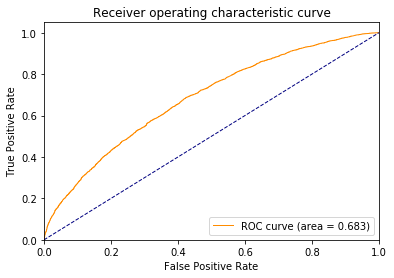

In [13]:
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))
plt.show()

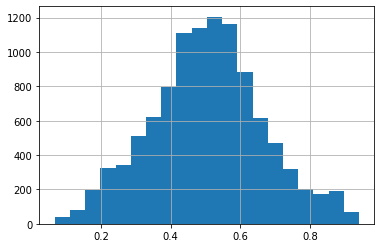

In [17]:
predicted = test_preds.reshape(-1)
pd.Series(predicted).hist(bins=20)
plt.show()

In [24]:
def probcats(nbins):
    df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy','lconf95','hconf95'])
    for pbot in np.linspace(0,1-1/nbins,nbins):
        ptop = pbot+1/nbins
        mask = (predicted>=pbot)&(predicted<ptop)
        count = int(mask.sum())
        if count>0:
            actual = pd.Series(y_test)[mask].values
            pred_prob = pd.Series(predicted)[mask].values
            pred_bin = pred_prob>.5
            acc = accuracy_score(actual, pred_bin)
            nsucc = sum(actual==pred_bin)
            confint = proportion_confint(nsucc, count)
            minconf = confint[0]
            maxconf = confint[1]
        else:
            acc = np.nan
            minconf = np.nan
            maxconf = np.nan
        row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 
                            'accuracy':[acc], 'lconf95':[minconf], 'hconf95':[maxconf]})
        df_acc = pd.concat([df_acc, row], sort=False)
    return(df_acc.set_index(['minprob','maxprob']))
df_acc = probcats(20)
df_acc

,,count,accuracy,lconf95,hconf95
minprob,maxprob,,,,
0.00,0.05,0,NaN,NaN,NaN
0.05,0.10,26,0.961538,0.887619,1.000000
0.10,0.15,82,0.914634,0.854155,0.975113
0.15,0.20,220,0.850000,0.802816,0.897184
0.20,0.25,362,0.743094,0.698085,0.788103
0.25,0.30,475,0.720000,0.679622,0.760378
0.30,0.35,629,0.707472,0.671920,0.743024
0.35,0.40,762,0.639108,0.605008,0.673207
0.40,0.45,1189,0.571909,0.543784,0.600034


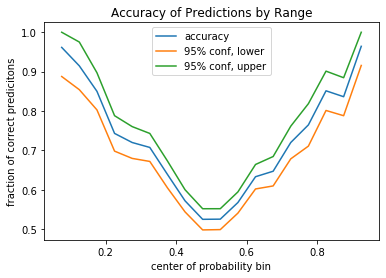

In [30]:
def display_perf(df):
    df = df.reset_index()
    df['avgprob'] = .5*(df.minprob + df.maxprob)
    ax = df.drop(['count','minprob','maxprob'],axis=1).set_index('avgprob').plot(
            title='Accuracy of Predictions by Range')
    ax.legend(labels=['accuracy', '95% conf, lower', '95% conf, upper'])
    ax.set(xlabel="center of probability bin", ylabel="fraction of correct predicitons")
    plt.show()
display_perf(df_acc)

In [33]:
df4 = probcats(4)
df4

,,count,accuracy,lconf95,hconf95
minprob,maxprob,,,,
0.00,0.25,690,0.805797,0.776281,0.835314
0.25,0.50,4379,0.604933,0.590453,0.619412
0.50,0.75,4666,0.593656,0.579564,0.607749
0.75,1.00,715,0.826573,0.798821,0.854325


In [34]:
len(y_test)

10450

In [1]:
(690+715)/10450

0.13444976076555024